# GIA - Práctica 2
## Segmentación

El objetivo de esta práctica es el desarrollo de una metodología para la segmentación automática de las regiones de fluido patológico en imágenes OCT.


In [62]:
# Connect to drive

from google.colab import drive
import os

drive.mount('/content/gdrive')

route = '/content/gdrive/MyDrive/GIA/VCA/P2/'

print('\nChange the directory to project route')
%cd $route

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Change the directory to project route
/content/gdrive/MyDrive/GIA/VCA/P2


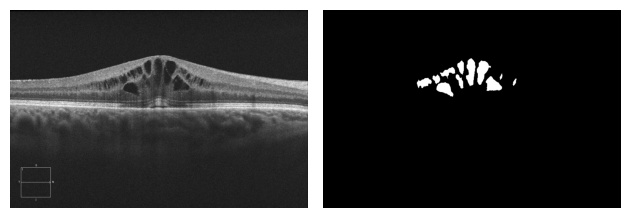

In [63]:
import matplotlib.pyplot as plt

# Aux function that shows an image and its corresponding mask in the same figure
def show(image, mask, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image, cmap="gray")
    ax[0].axis('off')
    if title is not None:
        fig.suptitle(title)
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

im = plt.imread(f"{route}OCT-dataset/images/sample_01.jpg")
mask = plt.imread(f"{route}OCT-dataset/masks/sample_01.jpg")
show(im, mask)

**Sugerencia**: Para el cálculo de métricas de rendimiento se puede utilizar la siguiente función auxiliar que permite obtener la máscara de segmentación a partir de las salidas de la red. La salida de la red es un valor positivo en coma flotante. La función sigmoidea restringe el dominio de salida entre 0 y 1. Como la máscara de salida es binaria, usamos un umbral para establecer los valores de la máscara de salida en 0 ó 1. Ten en cuenta que tal vez tengas que ajustar el umbral por defecto.

In [64]:
# Aux function to get binary segmentation mask
import torch
def get_segmentation_masks(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)
    masks = (probs > threshold) * 1.0
    return masks

# Aux function to show results
def show_result(orig, gt, prediction, title=None):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    ax = axes.ravel()

    images = [orig, gt, prediction, orig*prediction]
    titles = ['Orig', 'Gt', 'Result', 'Overlap']
    for i, (im, tit) in enumerate(zip(images, titles)):
        ax[i].imshow(im, cmap='gray')
        ax[i].set_title(tit)
        ax[i].axis('off')
    plt.show()

## UNet
UNet es una red convolucional diseñada para la segmentación de imágenes biomédicas. Sus tasas de éxito son altas incluso con pocas imágenes en el conjunto de entrenamiento.
En esta práctica abordaremos la tarea de segmentación usando una UNet. Los pasos generales a seguir son los siguientes:
1. Definir la arquitectura de red
2. Creación de dataset
   - Generar conjuntos de entrenamiento, validación y test
3. Entrenar la red
4. Seleccionar modelo en base a conjunto de validación
5. Test del modelo seleccionado

### Definición de la arquitectura de red

In [65]:
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

### Creación de Dataset

In [66]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import random
import cv2

class OCTDataset(Dataset):

    def __init__(self, image_path, mask_path, rsize = (416,624), transform = None):
        super().__init__()
        # Load all the filenames with extension tif from the image_path directory
        self.img_files = glob.glob(os.path.join(image_path,'*.jpg'))

        self.mask_files = []

        # We asume that each image has the same filename as its corresponding mask
        # but it is stored in another directory (mask_path)
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path, os.path.basename(img_path)))

        self.rsize = rsize  # Size to use in default Resize transform
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = plt.imread(img_path)
        mask = plt.imread(mask_path)
        if len(mask.shape) > 2:
            mask = mask[:,:,0]
        if len(image.shape) > 2:
            image = image[:,:,0]
        _, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY) # Make sure that mask is binary
        # Apply the defined transformations to both image and mask
        if self.transform is not None:
            seed = np.random.randint(2147483647) # make a seed with numpy generator
            random.seed(seed) # apply this seed to image transforms
            torch.manual_seed(seed)
            image = self.transform(image)
            random.seed(seed) # apply the same seed to mask transforms
            torch.manual_seed(seed)
            mask = self.transform(mask)
        else:
            t = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(self.rsize, interpolation= InterpolationMode.NEAREST),
                transforms.ToTensor()])

            image = t(image)
            mask = t(mask)

        return image, mask

    def __len__(self):
        return len(self.img_files)

Dataset len: 50


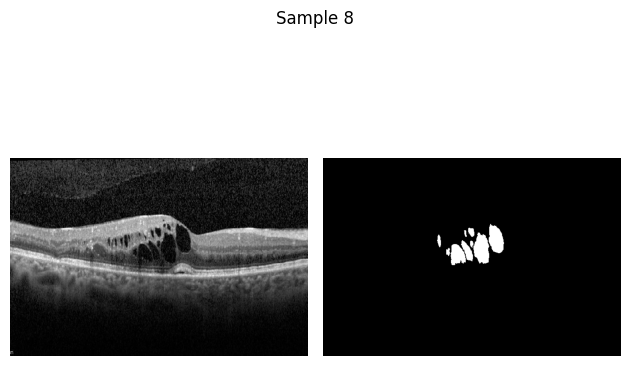

In [67]:
# Load some samples
simple_dataset = OCTDataset(f"{route}/OCT-dataset/images", f"{route}/OCT-dataset/masks")
print("Dataset len:", len(simple_dataset))
nsamples = 1
for _ in range(nsamples):
    idx = np.random.randint(0, len(simple_dataset))
    im, mask = simple_dataset[idx]
    show(im.squeeze(), mask.squeeze(), title=f"Sample {idx}")

### Partición del dataset en entrenamiento/validación

In [68]:
from sklearn.model_selection import train_test_split
import glob
import os

image_path = "OCT-dataset/images"
mask_path = "OCT-dataset/masks"

all_images = glob.glob(os.path.join(image_path, '*.jpg'))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Número de imágenes de entrenamiento: {len(train_imgs)}")
print(f"Número de imágenes de validación: {len(val_imgs)}")

Número de imágenes de entrenamiento: 40
Número de imágenes de validación: 10


### Creación de los Dataset y DataLoader para cada partición

In [69]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

# Transformación base para imágenes y máscaras (solo resize y tensorización)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 624), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Dataset modificado para usar solo las imágenes de cada split
class OCTSubsetDataset(OCTDataset):
    def __init__(self, img_list, image_path, mask_path, transform=None):
        self.img_files = img_list
        self.mask_files = [os.path.join(mask_path, os.path.basename(p)) for p in img_list]
        self.rsize = (416, 624)
        self.transform = transform

train_dataset = OCTSubsetDataset(train_imgs, image_path, mask_path, transform=transform)
val_dataset = OCTSubsetDataset(val_imgs, image_path, mask_path, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


### Entrenamiento del *baseline*

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = UNet(input_channels=1, n_class=1).to(device)  # Output 1 canal para máscara binaria

# Binary Cross Entropy con logits (más estable)
pos_weight = torch.tensor([60.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Device: cuda:0


In [71]:
def train_model(num_epochs=50, model_path="model.pth"):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        # Evaluación en validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)

        epoch_time = round(time.time() - start_time, 2)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time}")

        # Guardar el mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print("  ↳ Modelo guardado (el mejor hasta ahora)")

    return model

In [72]:
epochs = 3 # TODO: cambiar
baseline_path = "baseline_model.pth"

baseline = train_model(num_epochs=epochs,
                        model_path=baseline_path
                        )

Epoch [1/3] | Train Loss: 1.3288 | Val Loss: 1.2935 | Time: 9.9
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [2/3] | Train Loss: 1.3274 | Val Loss: 1.2923 | Time: 9.99
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [3/3] | Train Loss: 1.3262 | Val Loss: 1.2906 | Time: 10.75
  ↳ Modelo guardado (el mejor hasta ahora)


In [73]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, jaccard_score
import numpy as np
import matplotlib.pyplot as plt

# Función auxiliar para binarizar predicciones
def get_binary_mask(output, threshold=0.5):
    return (torch.sigmoid(output) > threshold).float()

def evaluate_thresholds(model, model_path, thresholds):
    # Cargar mejor modelo
    model.load_state_dict(torch.load(model_path))
    model.eval()

    results = np.zeros((len(thresholds), 6))

    for i, thresh in enumerate(thresholds):
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                preds = get_binary_mask(outputs, threshold=thresh)

                # Flatten para calcular métricas
                all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
                all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

        # Convertir a arrays
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)

        # Cálculo de métricas por pixel
        iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
        acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
        precision = precision_score(all_targets.flatten(), all_preds.flatten(), zero_division=0.0)
        recall = recall_score(all_targets.flatten(), all_preds.flatten())
        p_plus_r = precision + recall
        f1 = 0.0 if p_plus_r == 0.0 else ((precision * recall)/(p_plus_r))

        # print(f"IoU: {iou:.4f}")
        # print(f"Accuracy: {acc:.4f}")
        # print(f"Precision: {precision:.4f}")
        # print(f"Recall: {recall:.4f}")
        # print(f"F1 score: {f1:.4f}")

        results[i] = [thresh, iou, acc, precision, recall, f1]

    return results

In [74]:
gap = 0.05
thresholds = np.arange(gap, 1, gap)

baseline_results = evaluate_thresholds(baseline, model_path=baseline_path, thresholds=thresholds)

In [75]:
def plot_threshold_results(results, thresholds):
    iou_results  = results[:, 1]
    acc_results  = results[:, 2]
    prec_results = results[:, 3]
    rec_results  = results[:, 4]
    f1_results   = results[:, 5]

    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, iou_results, label="IoU")
    plt.plot(thresholds, acc_results, label="Accuracy")
    plt.plot(thresholds, prec_results, label="Precision")
    plt.plot(thresholds, rec_results, label="Recall")
    plt.plot(thresholds, f1_results, label="F1-Score")
    plt.legend(loc="center left")
    plt.title("Métricas con diferentes umbrales")
    plt.xticks(thresholds)
    plt.ylabel("Valor métrica")
    plt.xlabel("Umbral")
    plt.show()

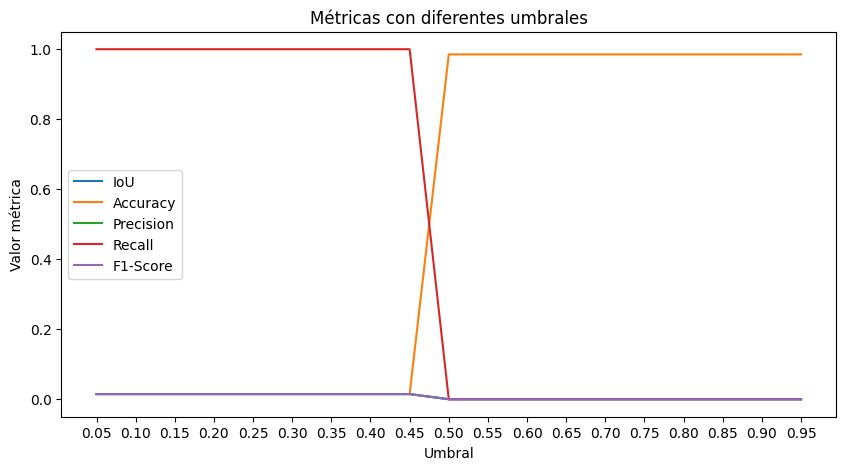

In [76]:
plot_threshold_results(baseline_results, thresholds=thresholds)

In [77]:
def try_model_with_samples(model, threshold):
    # Mostrar ejemplos del conjunto de validación
    num_samples = 4
    model.eval()

    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            images = images.to(device)
            outputs = model(images)
            preds = get_binary_mask(outputs, threshold=thresh).cpu()

            for j in range(min(num_samples, images.size(0))):
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
                ax[0].set_title("Imagen original")
                ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
                ax[1].set_title("Máscara real")
                ax[2].imshow(preds[j].squeeze(), cmap="gray")
                ax[2].set_title("Predicción")
                for a in ax:
                    a.axis('off')
                plt.show()

            break  # solo una tanda de imágenes

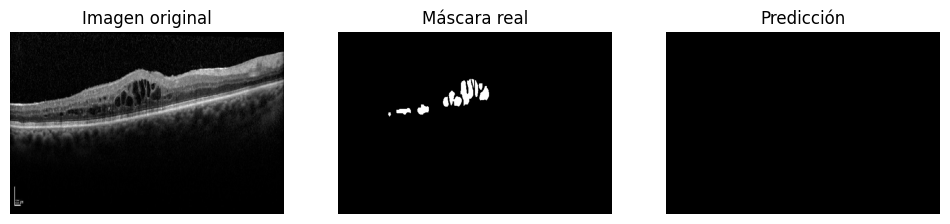

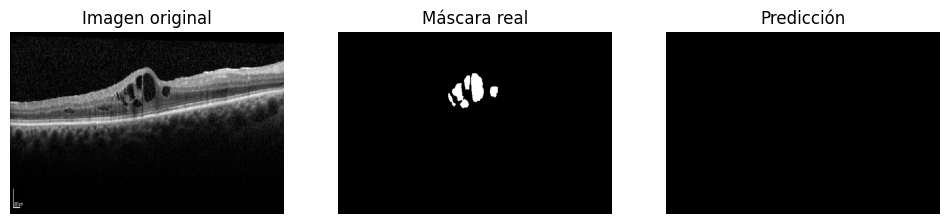

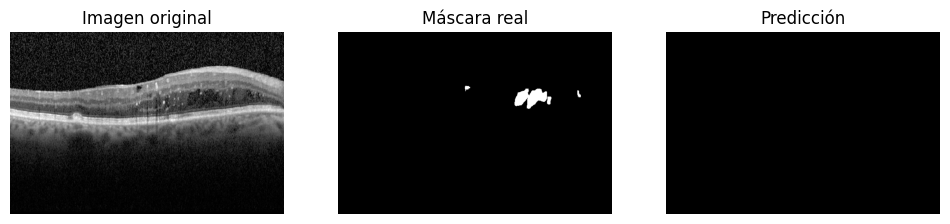

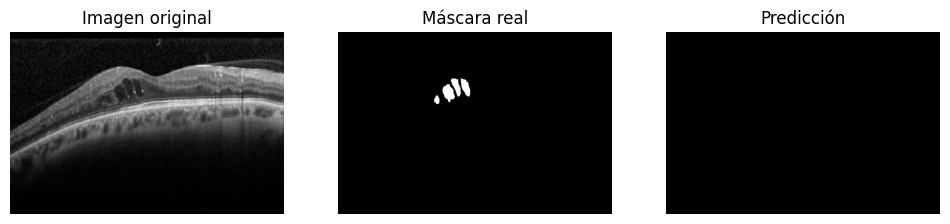

In [78]:
thresh = 0.95

try_model_with_samples(model=baseline, threshold=thresh)

## Mejoras Propuestas

### Sobre el modelo

Batch Normalization y Dropout

In [ ]:
import torch.nn as nn

def double_conv(in_channels, out_channels, dropout_prob=0.0):
    layers = [
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if dropout_prob > 0.0:
        layers.append(nn.Dropout2d(p=dropout_prob))
    return nn.Sequential(*layers)

class UNet(nn.Module):
    def __init__(self, input_channels, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256, dropout_prob=0.3)
        self.dconv_down4 = double_conv(256, 512, dropout_prob=0.3)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256, dropout_prob=0.3)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

#### Entrenamiento mejoras

Device: cuda:0
[1/50] Train Loss: 1.0117 | Val Loss: 1.2664 | Time: 11.56s
  ↳ Modelo mejorado guardado
[2/50] Train Loss: 0.7536 | Val Loss: 1.2726 | Time: 12.11s
[3/50] Train Loss: 0.6650 | Val Loss: 1.2899 | Time: 11.38s
[4/50] Train Loss: 0.6246 | Val Loss: 1.3128 | Time: 11.31s
[5/50] Train Loss: 0.5722 | Val Loss: 1.3278 | Time: 11.24s
[6/50] Train Loss: 0.5208 | Val Loss: 1.3246 | Time: 11.1s
[7/50] Train Loss: 0.5073 | Val Loss: 1.2713 | Time: 11.18s
[8/50] Train Loss: 0.4778 | Val Loss: 1.0933 | Time: 11.22s
  ↳ Modelo mejorado guardado
[9/50] Train Loss: 0.4490 | Val Loss: 0.9789 | Time: 11.86s
  ↳ Modelo mejorado guardado
[10/50] Train Loss: 0.4501 | Val Loss: 0.7617 | Time: 11.81s
  ↳ Modelo mejorado guardado
[11/50] Train Loss: 0.4505 | Val Loss: 0.5548 | Time: 11.92s
  ↳ Modelo mejorado guardado
[12/50] Train Loss: 0.3974 | Val Loss: 0.5879 | Time: 11.55s
[13/50] Train Loss: 0.4109 | Val Loss: 0.4288 | Time: 11.2s
  ↳ Modelo mejorado guardado
[14/50] Train Loss: 0.3890 | 

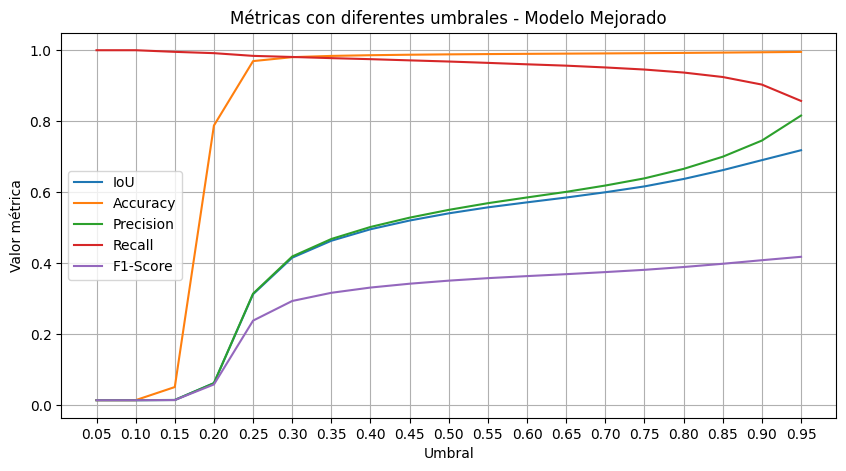

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import precision_score, recall_score, accuracy_score, jaccard_score
import numpy as np
import matplotlib.pyplot as plt

# Configuración
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Modelo mejorado
model_improved = UNet(input_channels=1, n_class=1).to(device)

# Función de pérdida y optimizador
pos_weight = torch.tensor([60.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_improved.parameters(), lr=1e-4)

# Entrenamiento
num_epochs = 50
best_val_loss = float('inf')
model_path_improved = "best_unet_model_improved.pth"

for epoch in range(num_epochs):
    start_time = time.time()
    model_improved.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model_improved(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Validación
    model_improved.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model_improved(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)

    epoch_time = round(time.time() - start_time, 2)
    print(f"[{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_improved.state_dict(), model_path_improved)
        print("  ↳ Modelo mejorado guardado")

# --------- EVALUACIÓN ---------

def get_binary_mask(output, threshold=0.5):
    return (torch.sigmoid(output) > threshold).float()

# Métricas para varios umbrales
model_improved.load_state_dict(torch.load(model_path_improved))
model_improved.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model_improved(images)
            preds = get_binary_mask(outputs, threshold=thresh)
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = ((precision * recall)/(precision + recall))

    results[i] = [thresh, iou, acc, precision, recall, f1]

# --------- VISUALIZACIÓN ---------

iou_results  = results[:, 1]
acc_results  = results[:, 2]
prec_results = results[:, 3]
rec_results  = results[:, 4]
f1_results   = results[:, 5]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, iou_results, label="IoU")
plt.plot(thresholds, acc_results, label="Accuracy")
plt.plot(thresholds, prec_results, label="Precision")
plt.plot(thresholds, rec_results, label="Recall")
plt.plot(thresholds, f1_results, label="F1-Score")
plt.legend(loc="center left")
plt.title("Métricas con diferentes umbrales - Modelo Mejorado")
plt.xticks(thresholds)
plt.ylabel("Valor métrica")
plt.xlabel("Umbral")
plt.grid(True)
plt.show()


#### Métricas numéricas e imágenes resultantes de la mejora

In [ ]:
import pandas as pd

# Mostramos los resultados como DataFrame
metrics_df = pd.DataFrame(results, columns=["Threshold", "IoU", "Accuracy", "Precision", "Recall", "F1-Score"])
pd.set_option("display.precision", 4)
print("Resumen de métricas por umbral:")
display(metrics_df)

Resumen de métricas por umbral:


Threshold     IoU  Accuracy  Precision  Recall  F1-Score
0        0.05  0.0142    0.0142     0.0142  1.0000    0.0140
1        0.10  0.0142    0.0142     0.0142  1.0000    0.0140
2        0.15  0.0146    0.0510     0.0146  0.9954    0.0144
3        0.20  0.0621    0.7879     0.0621  0.9917    0.0584
4        0.25  0.3127    0.9694     0.3143  0.9841    0.2382
5        0.30  0.4155    0.9805     0.4189  0.9810    0.2936
6        0.35  0.4633    0.9840     0.4682  0.9777    0.3166
7        0.40  0.4956    0.9860     0.5020  0.9748    0.3314
8        0.45  0.5202    0.9873     0.5283  0.9714    0.3422
9        0.50  0.5404    0.9883     0.5502  0.9682    0.3508
10       0.55  0.5573    0.9892     0.5691  0.9643    0.3579
11       0.60  0.5714    0.9898     0.5852  0.9603    0.3636
12       0.65  0.5850    0.9904     0.6010  0.9565    0.3691
13       0.70  0.5999    0.9910     0.6188  0.9515    0.3749
14       0.75  0.6164    0.9917     0.6390  0.9456    0.3813
15       0.80  0.6373    0.9925     0.6657  0.9371    0.3892
16       0.85  0.6622    0.9933     0.7000  0.9245    0.3984
17       0.90  0.6903    0.9943     0.7455  0.9032    0.4084
18       0.95  0.7183    0.9952     0.8160  0.8571    0.4180

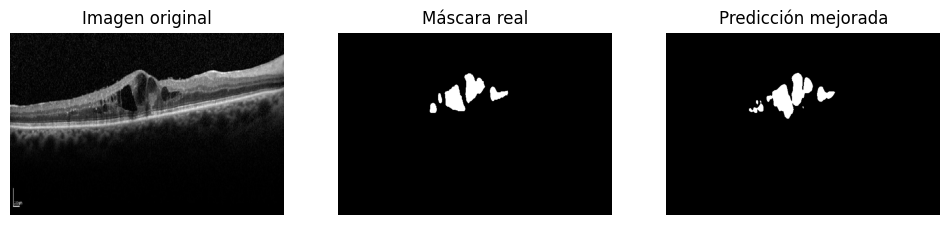

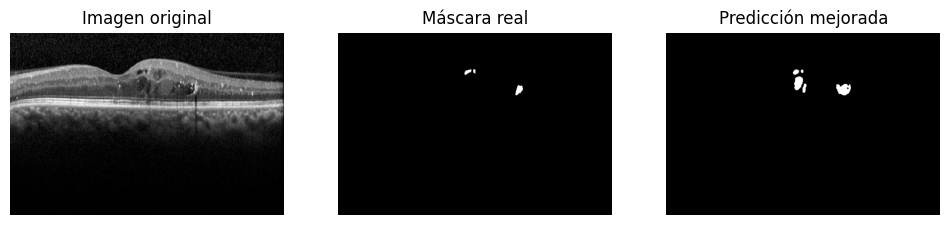

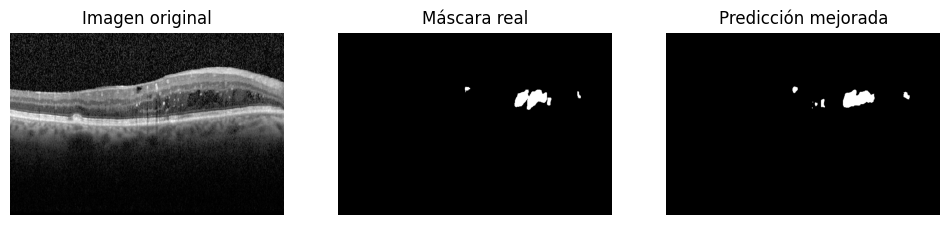

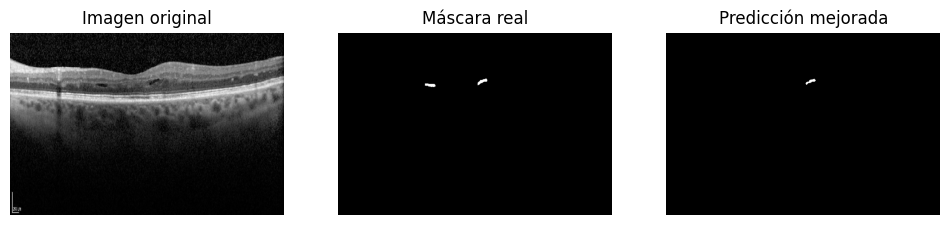

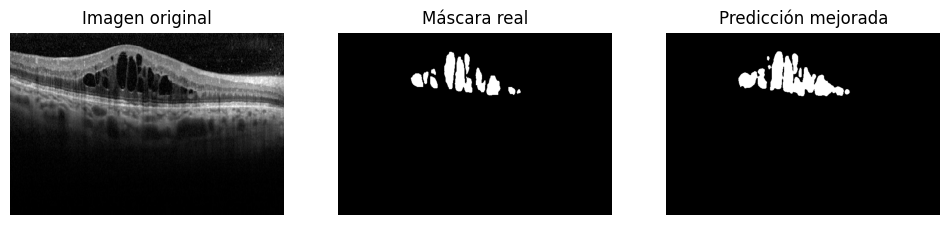

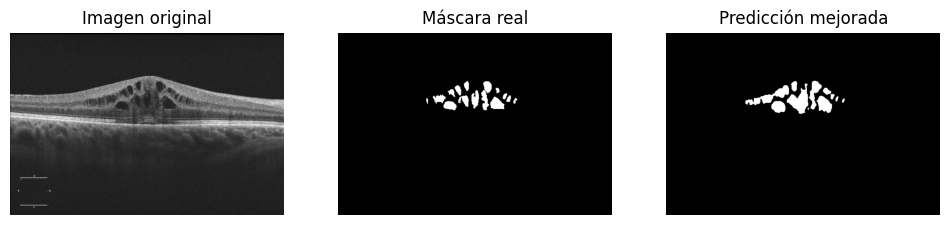

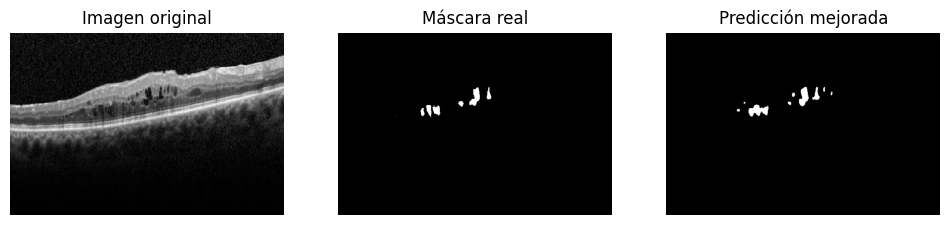

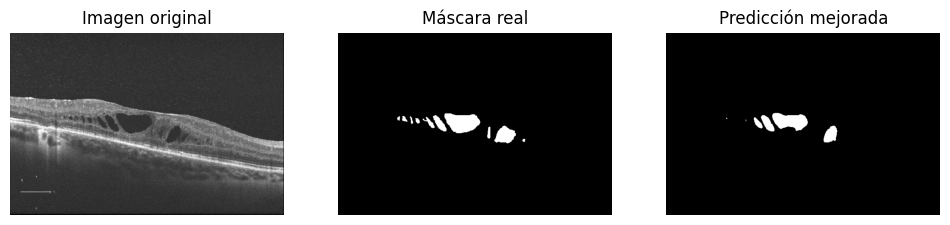

In [ ]:
# Visualización de resultados del modelo mejorado
thresh = 0.9  # umbral
num_samples = 8
model_improved.eval()

with torch.no_grad():
    for i, (images, masks) in enumerate(val_loader):
        images = images.to(device)
        outputs = model_improved(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(num_samples, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción mejorada")
            for a in ax:
                a.axis('off')
            plt.show()

        break  # solo una tanda de imágenes


### Preprocesamiento y DataAugmentation

In [ ]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

# Transformación con data augmentation (solo para entrenamiento)
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 624), interpolation=InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # pequeños desplazamientos
    transforms.GaussianBlur(kernel_size=3, sigma=(0.05, 1.0)),
    transforms.ToTensor()
])

# Validación sin augmentación
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 624), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Redefinicion datasets
train_dataset = OCTSubsetDataset(train_imgs, image_path, mask_path, transform=train_transform)
val_dataset = OCTSubsetDataset(val_imgs, image_path, mask_path, transform=val_transform)

# Redefinicion dataloaders (igual que antes)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


#### Sobre arquitecrura base

##### Entrenamiento

In [ ]:
# Modelo base (sin mejoras de arquitectura)
model_aug_only = UNet(input_channels=1, n_class=1).to(device)

# Pérdida clásica
pos_weight = torch.tensor([60.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_aug_only.parameters(), lr=1e-4)

model_path_aug_only = "best_unet_aug_only.pth"
best_val_loss = float('inf')

for epoch in range(50):
    model_aug_only.train()
    train_loss = 0.0
    for images, masks in train_loader:  # Usa train_loader con data augmentation
        images, masks = images.to(device), masks.to(device)
        outputs = model_aug_only(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    model_aug_only.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_aug_only(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"[{epoch+1}/50] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_aug_only.state_dict(), model_path_aug_only)
        print(" ↳ Modelo base con augmentación guardado")


[1/50] Train Loss: 1.1295 | Val Loss: 1.2796
 ↳ Modelo base con augmentación guardado
[2/50] Train Loss: 0.8493 | Val Loss: 1.2735
 ↳ Modelo base con augmentación guardado
[3/50] Train Loss: 0.7215 | Val Loss: 1.2666
 ↳ Modelo base con augmentación guardado
[4/50] Train Loss: 0.6493 | Val Loss: 1.2678
[5/50] Train Loss: 0.6249 | Val Loss: 1.2925
[6/50] Train Loss: 0.5808 | Val Loss: 1.3291
[7/50] Train Loss: 0.5472 | Val Loss: 1.1580
 ↳ Modelo base con augmentación guardado
[8/50] Train Loss: 0.5116 | Val Loss: 1.0332
 ↳ Modelo base con augmentación guardado
[9/50] Train Loss: 0.5000 | Val Loss: 0.7640
 ↳ Modelo base con augmentación guardado
[10/50] Train Loss: 0.5127 | Val Loss: 0.4803
 ↳ Modelo base con augmentación guardado
[11/50] Train Loss: 0.4889 | Val Loss: 0.4690
 ↳ Modelo base con augmentación guardado
[12/50] Train Loss: 0.4611 | Val Loss: 0.4226
 ↳ Modelo base con augmentación guardado
[13/50] Train Loss: 0.4296 | Val Loss: 0.4065
 ↳ Modelo base con augmentación guardado
[

##### Evaluación

In [ ]:
model_aug_only.load_state_dict(torch.load(model_path_aug_only))
model_aug_only.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results_aug_only = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_aug_only(images)
            preds = get_binary_mask(outputs, threshold=thresh)
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = (precision * recall) / (precision + recall)

    results_aug_only[i] = [thresh, iou, acc, precision, recall, f1]

##### Gráfica y métricas

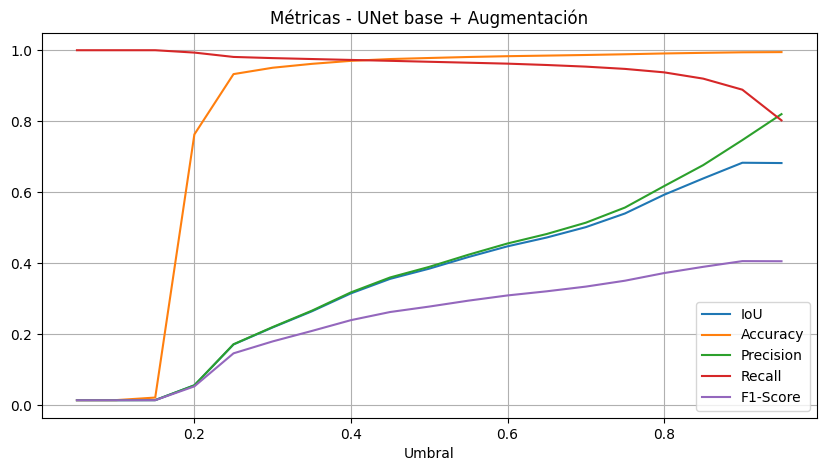

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, results_aug_only[:, 1], label="IoU")
plt.plot(thresholds, results_aug_only[:, 2], label="Accuracy")
plt.plot(thresholds, results_aug_only[:, 3], label="Precision")
plt.plot(thresholds, results_aug_only[:, 4], label="Recall")
plt.plot(thresholds, results_aug_only[:, 5], label="F1-Score")
plt.legend()
plt.title("Métricas - UNet base + Augmentación")
plt.xlabel("Umbral")
plt.grid(True)
plt.show()

In [ ]:
metrics_aug_only_df = pd.DataFrame(results_aug_only, columns=["Threshold", "IoU", "Accuracy", "Precision", "Recall", "F1-Score"])
print("Resumen de métricas por umbral:")
display(metrics_aug_only_df)

Resumen de métricas por umbral:


Threshold     IoU  Accuracy  Precision  Recall  F1-Score
0        0.05  0.0142    0.0142     0.0142  1.0000    0.0140
1        0.10  0.0142    0.0143     0.0142  1.0000    0.0140
2        0.15  0.0143    0.0215     0.0143  1.0000    0.0141
3        0.20  0.0560    0.7628     0.0560  0.9933    0.0530
4        0.25  0.1710    0.9327     0.1716  0.9811    0.1461
5        0.30  0.2190    0.9506     0.2201  0.9778    0.1796
6        0.35  0.2643    0.9616     0.2661  0.9752    0.2091
7        0.40  0.3150    0.9701     0.3178  0.9726    0.2395
8        0.45  0.3558    0.9751     0.3598  0.9701    0.2624
9        0.50  0.3846    0.9781     0.3896  0.9675    0.2778
10       0.55  0.4174    0.9809     0.4238  0.9648    0.2945
11       0.60  0.4475    0.9832     0.4555  0.9622    0.3092
12       0.65  0.4723    0.9848     0.4822  0.9584    0.3208
13       0.70  0.5016    0.9866     0.5141  0.9538    0.3340
14       0.75  0.5400    0.9886     0.5567  0.9474    0.3507
15       0.80  0.5928    0.9909     0.6171  0.9377    0.3722
16       0.85  0.6387    0.9926     0.6763  0.9199    0.3898
17       0.90  0.6830    0.9942     0.7468  0.8888    0.4058
18       0.95  0.6821    0.9947     0.8199  0.8023    0.4055

##### Visualización de predicciones

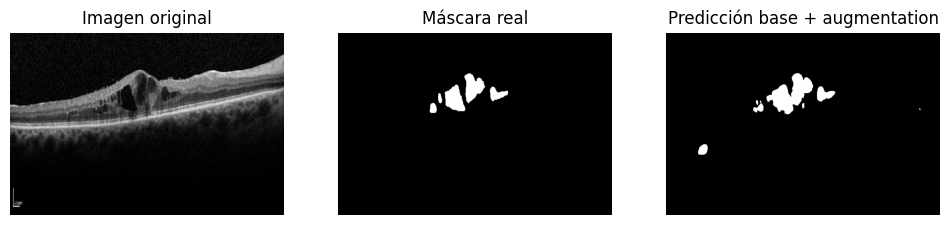

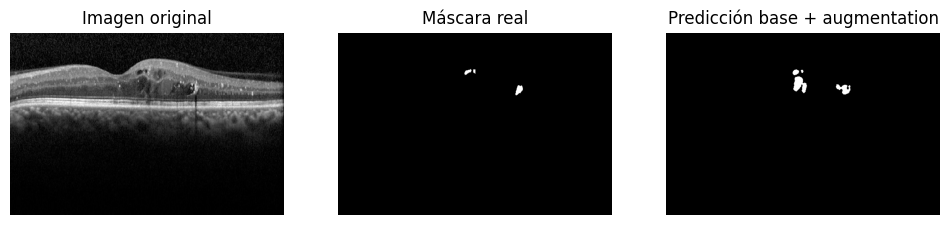

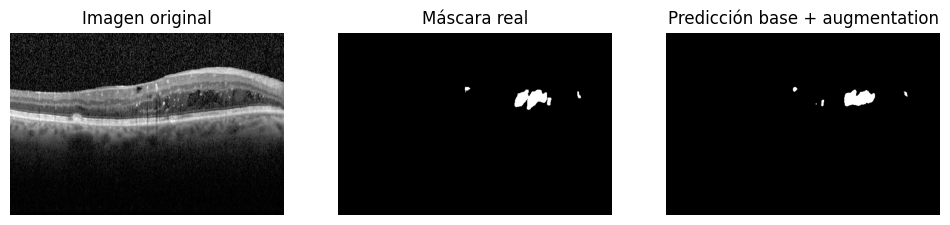

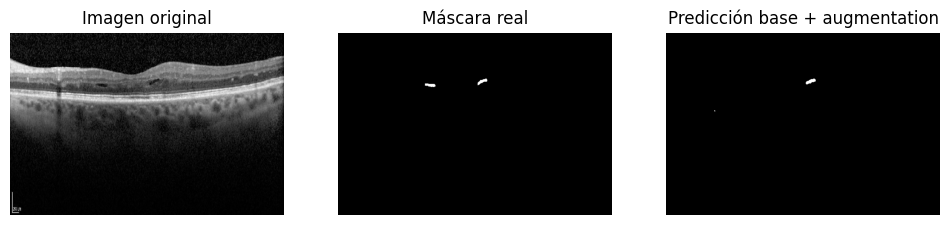

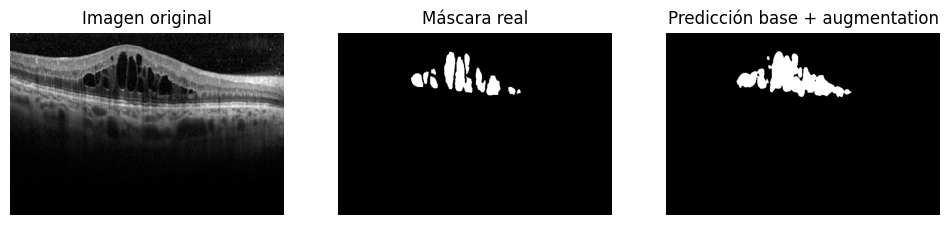

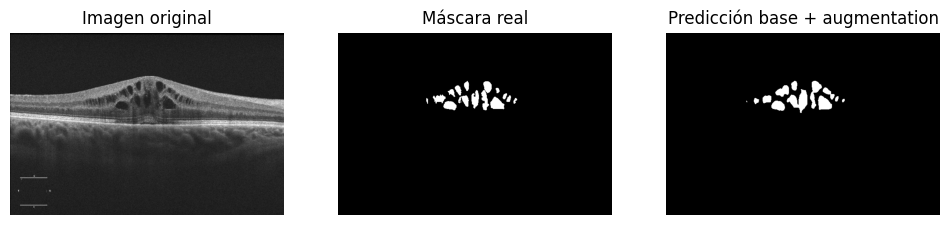

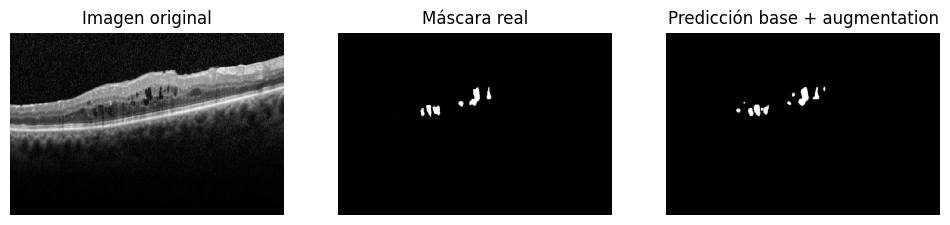

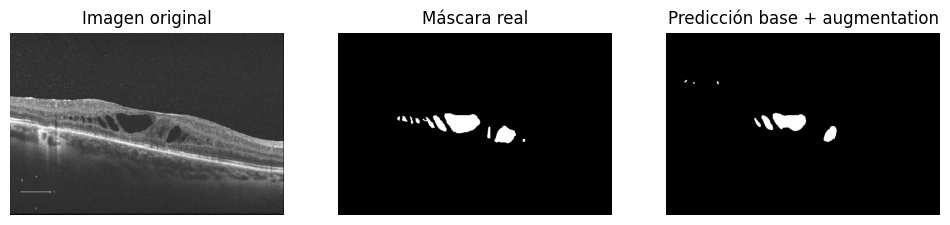

In [ ]:
thresh = 0.9
model_aug_only.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model_aug_only(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(8, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción base + augmentation")
            for a in ax: a.axis('off')
            plt.show()
        break

#### Sobre arquitectura mejorada

##### Entrenamiento y evaluación para Data Augmentation

In [ ]:
# Redefinicion del modelo base (sin mejoras de arquitectura)
model_augmented = UNet(input_channels=1, n_class=1).to(device)

# Pérdida y optimizador
pos_weight = torch.tensor([60.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_augmented.parameters(), lr=1e-4)

# Entrenamiento
num_epochs = 50
best_val_loss = float('inf')
model_path_augmented = "best_unet_model_augmented.pth"

for epoch in range(num_epochs):
    start_time = time.time()
    model_augmented.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model_augmented(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    model_augmented.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model_augmented(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)

    epoch_time = round(time.time() - start_time, 2)
    print(f"[{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_augmented.state_dict(), model_path_augmented)
        print("  ↳ Modelo con data augmentation guardado")


[1/50] Train Loss: 1.1600 | Val Loss: 1.2733 | Time: 11.75s
  ↳ Modelo con data augmentation guardado
[2/50] Train Loss: 0.9062 | Val Loss: 1.2687 | Time: 12.76s
  ↳ Modelo con data augmentation guardado
[3/50] Train Loss: 0.7557 | Val Loss: 1.2684 | Time: 12.21s
  ↳ Modelo con data augmentation guardado
[4/50] Train Loss: 0.6992 | Val Loss: 1.2717 | Time: 13.23s
[5/50] Train Loss: 0.6579 | Val Loss: 1.2782 | Time: 12.82s
[6/50] Train Loss: 0.5981 | Val Loss: 1.2627 | Time: 12.51s
  ↳ Modelo con data augmentation guardado
[7/50] Train Loss: 0.5802 | Val Loss: 1.2132 | Time: 12.06s
  ↳ Modelo con data augmentation guardado
[8/50] Train Loss: 0.5384 | Val Loss: 1.0523 | Time: 12.95s
  ↳ Modelo con data augmentation guardado
[9/50] Train Loss: 0.5344 | Val Loss: 0.8436 | Time: 13.48s
  ↳ Modelo con data augmentation guardado
[10/50] Train Loss: 0.5125 | Val Loss: 0.6971 | Time: 13.51s
  ↳ Modelo con data augmentation guardado
[11/50] Train Loss: 0.4923 | Val Loss: 0.5622 | Time: 12.21s
  

##### Métricas y gráfica

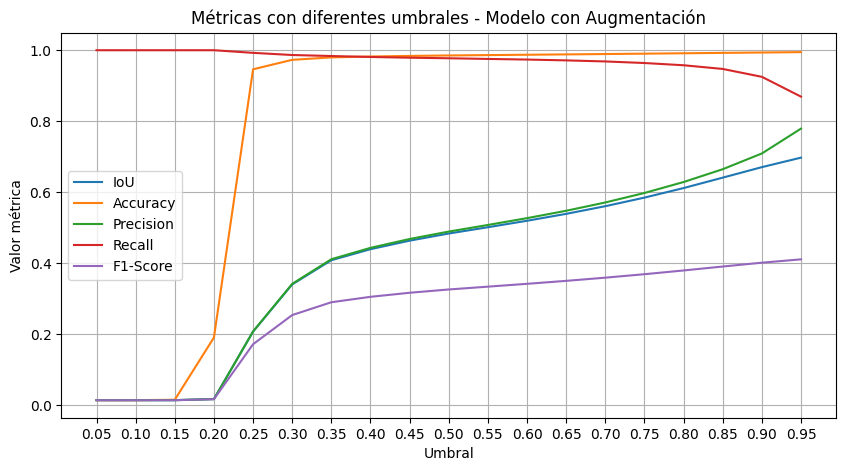

In [ ]:
# Evaluacion modelo entrenado con augmentación
model_augmented.load_state_dict(torch.load(model_path_augmented))
model_augmented.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results_aug = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model_augmented(images)
            preds = get_binary_mask(outputs, threshold=thresh)
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = (precision * recall) / (precision + recall)

    results_aug[i] = [thresh, iou, acc, precision, recall, f1]

# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(thresholds, results_aug[:, 1], label="IoU")
plt.plot(thresholds, results_aug[:, 2], label="Accuracy")
plt.plot(thresholds, results_aug[:, 3], label="Precision")
plt.plot(thresholds, results_aug[:, 4], label="Recall")
plt.plot(thresholds, results_aug[:, 5], label="F1-Score")
plt.legend(loc="center left")
plt.title("Métricas con diferentes umbrales - Modelo con Augmentación")
plt.xticks(thresholds)
plt.ylabel("Valor métrica")
plt.xlabel("Umbral")
plt.grid(True)
plt.show()

##### Métricas numéricas y predicciones nuevas

In [ ]:
# Mostramos tabla de métricas
import pandas as pd

metrics_aug_df = pd.DataFrame(results_aug, columns=["Threshold", "IoU", "Accuracy", "Precision", "Recall", "F1-Score"])
print("Resumen de métricas por umbral:")
display(metrics_aug_df)

Resumen de métricas por umbral:


Threshold     IoU  Accuracy  Precision  Recall  F1-Score
0        0.05  0.0142    0.0142     0.0142  1.0000    0.0140
1        0.10  0.0142    0.0142     0.0142  1.0000    0.0140
2        0.15  0.0142    0.0153     0.0142  1.0000    0.0140
3        0.20  0.0172    0.1906     0.0172  1.0000    0.0169
4        0.25  0.2073    0.9463     0.2077  0.9926    0.1717
5        0.30  0.3402    0.9729     0.3418  0.9865    0.2539
6        0.35  0.4084    0.9798     0.4112  0.9837    0.2900
7        0.40  0.4394    0.9823     0.4432  0.9810    0.3053
8        0.45  0.4635    0.9840     0.4682  0.9789    0.3167
9        0.50  0.4836    0.9852     0.4891  0.9774    0.3260
10       0.55  0.5013    0.9863     0.5077  0.9754    0.3339
11       0.60  0.5196    0.9873     0.5269  0.9737    0.3419
12       0.65  0.5390    0.9882     0.5477  0.9714    0.3502
13       0.70  0.5606    0.9893     0.5711  0.9684    0.3592
14       0.75  0.5848    0.9903     0.5979  0.9639    0.3690
15       0.80  0.6117    0.9914     0.6287  0.9576    0.3795
16       0.85  0.6411    0.9925     0.6648  0.9472    0.3906
17       0.90  0.6706    0.9936     0.7092  0.9250    0.4014
18       0.95  0.6974    0.9947     0.7792  0.8691    0.4109

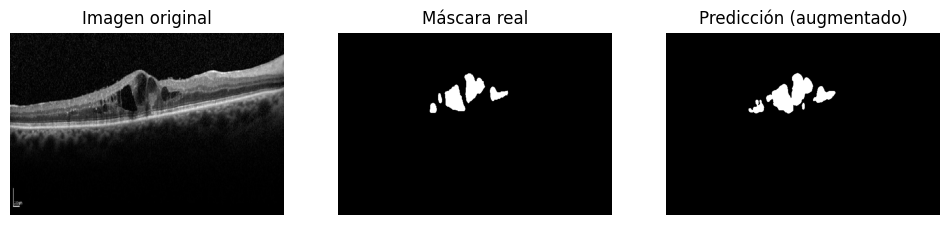

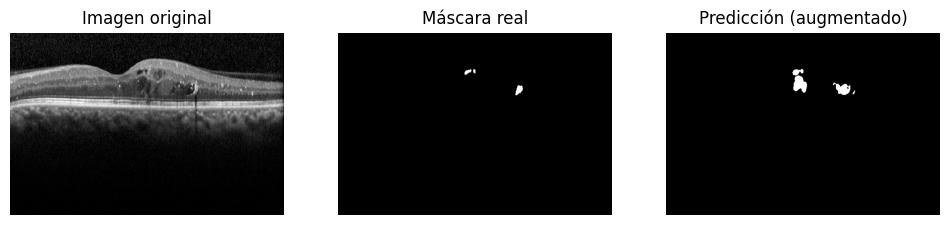

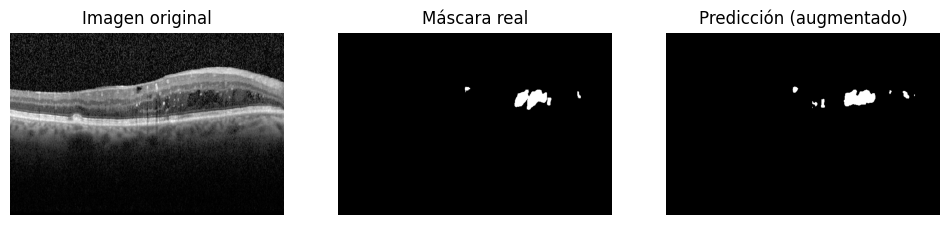

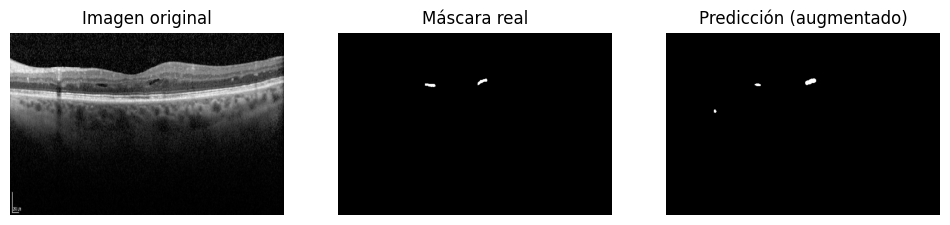

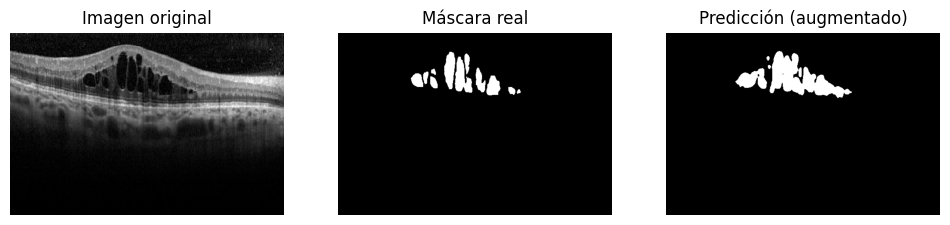

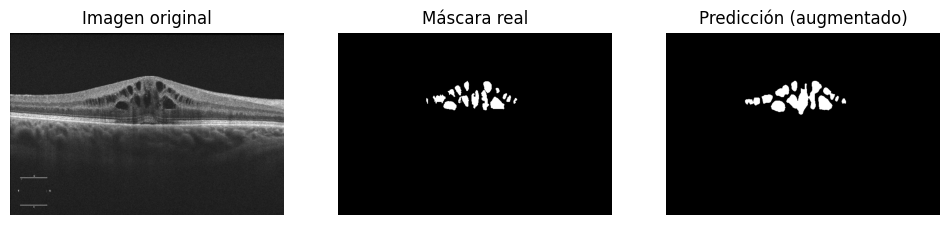

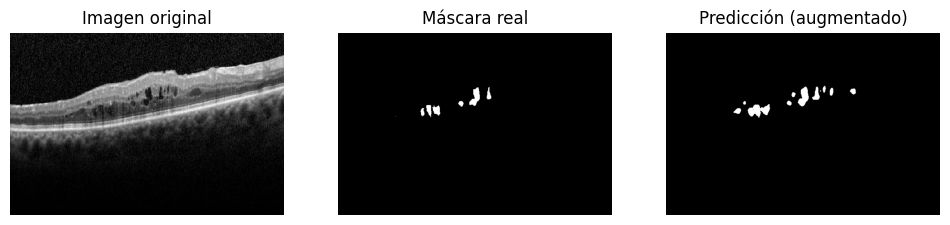

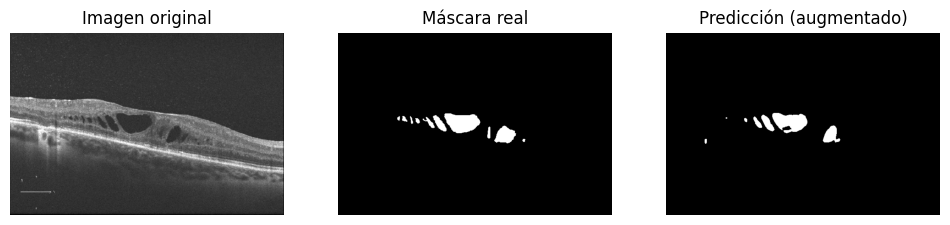

In [ ]:
# Visualizamos predicciones del modelo entrenado con augmentación
thresh = 0.9
model_augmented.eval()

with torch.no_grad():
    for i, (images, masks) in enumerate(val_loader):
        images = images.to(device)
        outputs = model_augmented(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(8, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción (augmentado)")
            for a in ax:
                a.axis('off')
            plt.show()

        break

## Mejora función de pérdida para regiones desbalanceadas

In [ ]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)
        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        return 1 - dice

# BCE + Dice
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, pos_weight=None):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        dice_loss = self.dice(logits, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss


### Con arquitectura base

In [ ]:
# Modelo base
model_bce_dice = UNet(input_channels=1, n_class=1).to(device)

# Nueva función de pérdida: BCE + Dice
criterion = BCEDiceLoss(bce_weight=0.5, pos_weight=torch.tensor([60.0]).to(device))
optimizer = optim.Adam(model_bce_dice.parameters(), lr=1e-4)

model_path_bce_dice = "best_unet_bce_dice.pth"
best_val_loss = float('inf')

# Entrenamiento
for epoch in range(50):
    model_bce_dice.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_bce_dice(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    model_bce_dice.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_bce_dice(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"[{epoch+1}/50] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_bce_dice.state_dict(), model_path_bce_dice)
        print(" ↳ Modelo BCE+Dice (base) guardado")


[1/50] Train Loss: 1.0647 | Val Loss: 1.1209
 ↳ Modelo BCE+Dice (base) guardado
[2/50] Train Loss: 0.9340 | Val Loss: 1.1210
[3/50] Train Loss: 0.8970 | Val Loss: 1.1202
 ↳ Modelo BCE+Dice (base) guardado
[4/50] Train Loss: 0.8401 | Val Loss: 1.1216
[5/50] Train Loss: 0.8134 | Val Loss: 1.1271
[6/50] Train Loss: 0.7817 | Val Loss: 1.1343
[7/50] Train Loss: 0.7755 | Val Loss: 1.1283
[8/50] Train Loss: 0.7443 | Val Loss: 1.1012
 ↳ Modelo BCE+Dice (base) guardado
[9/50] Train Loss: 0.7428 | Val Loss: 1.0007
 ↳ Modelo BCE+Dice (base) guardado
[10/50] Train Loss: 0.7392 | Val Loss: 0.9053
 ↳ Modelo BCE+Dice (base) guardado
[11/50] Train Loss: 0.7352 | Val Loss: 0.7396
 ↳ Modelo BCE+Dice (base) guardado
[12/50] Train Loss: 0.7215 | Val Loss: 0.7551
[13/50] Train Loss: 0.7095 | Val Loss: 0.6938
 ↳ Modelo BCE+Dice (base) guardado
[14/50] Train Loss: 0.7023 | Val Loss: 0.6978
[15/50] Train Loss: 0.6996 | Val Loss: 0.7037
[16/50] Train Loss: 0.6910 | Val Loss: 0.6931
 ↳ Modelo BCE+Dice (base) gu

#### Evaluación y métricas

In [ ]:
# Evaluación del modelo base con BCE+Dice
model_bce_dice.load_state_dict(torch.load("best_unet_bce_dice.pth"))
model_bce_dice.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results_bce_dice = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_bce_dice(images)
            preds = get_binary_mask(outputs, threshold=thresh)
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = (precision * recall) / (precision + recall)

    results_bce_dice[i] = [thresh, iou, acc, precision, recall, f1]


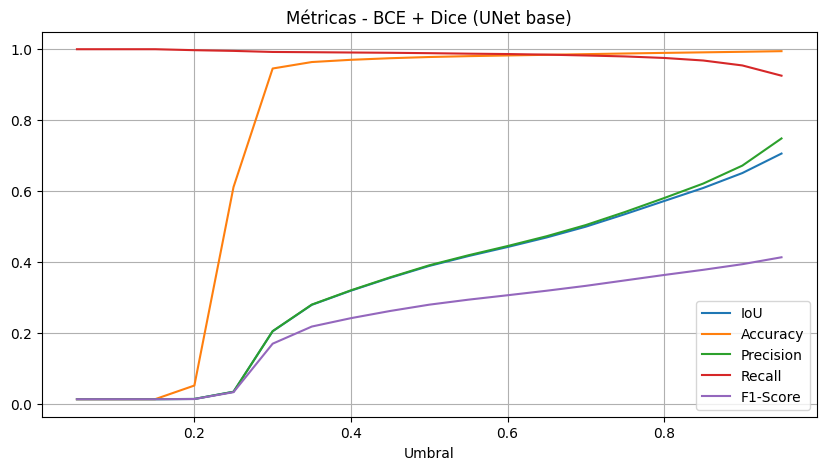

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, results_bce_dice[:, 1], label="IoU")
plt.plot(thresholds, results_bce_dice[:, 2], label="Accuracy")
plt.plot(thresholds, results_bce_dice[:, 3], label="Precision")
plt.plot(thresholds, results_bce_dice[:, 4], label="Recall")
plt.plot(thresholds, results_bce_dice[:, 5], label="F1-Score")
plt.legend()
plt.title("Métricas - BCE + Dice (UNet base)")
plt.xlabel("Umbral")
plt.grid(True)
plt.show()


In [ ]:
metrics_bce_dice_df = pd.DataFrame(results_bce_dice, columns=["Threshold", "IoU", "Accuracy", "Precision", "Recall", "F1-Score"])
print("Resumen de métricas por umbral:")
display(metrics_bce_dice_df)


Resumen de métricas por umbral:


Threshold     IoU  Accuracy  Precision  Recall  F1-Score
0        0.05  0.0142    0.0142     0.0142  1.0000    0.0140
1        0.10  0.0142    0.0142     0.0142  1.0000    0.0140
2        0.15  0.0142    0.0142     0.0142  1.0000    0.0140
3        0.20  0.0147    0.0525     0.0147  0.9973    0.0145
4        0.25  0.0350    0.6116     0.0350  0.9953    0.0338
5        0.30  0.2054    0.9457     0.2058  0.9923    0.1704
6        0.35  0.2799    0.9639     0.2806  0.9916    0.2187
7        0.40  0.3198    0.9702     0.3208  0.9907    0.2423
8        0.45  0.3560    0.9747     0.3573  0.9900    0.2625
9        0.50  0.3895    0.9781     0.3912  0.9889    0.2803
10       0.55  0.4172    0.9805     0.4195  0.9875    0.2944
11       0.60  0.4427    0.9824     0.4455  0.9864    0.3069
12       0.65  0.4697    0.9843     0.4732  0.9848    0.3196
13       0.70  0.5001    0.9861     0.5046  0.9824    0.3334
14       0.75  0.5354    0.9880     0.5414  0.9797    0.3487
15       0.80  0.5723    0.9897     0.5806  0.9754    0.3640
16       0.85  0.6091    0.9912     0.6215  0.9682    0.3785
17       0.90  0.6512    0.9928     0.6721  0.9543    0.3944
18       0.95  0.7061    0.9945     0.7486  0.9254    0.4139

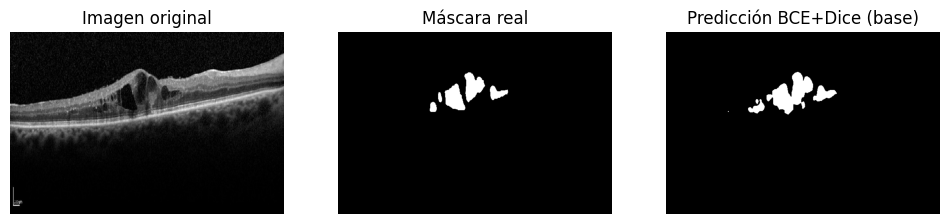

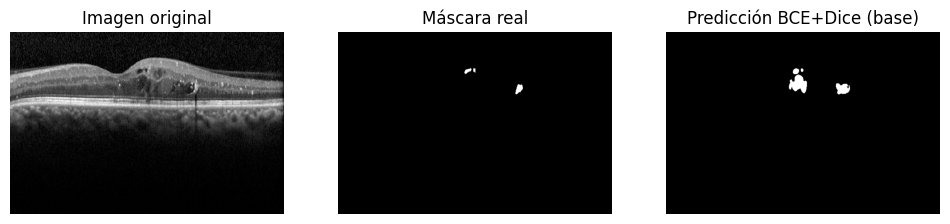

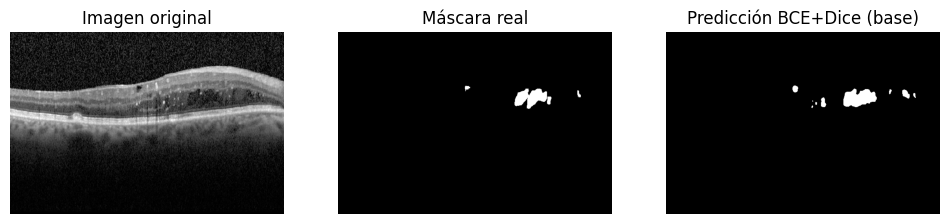

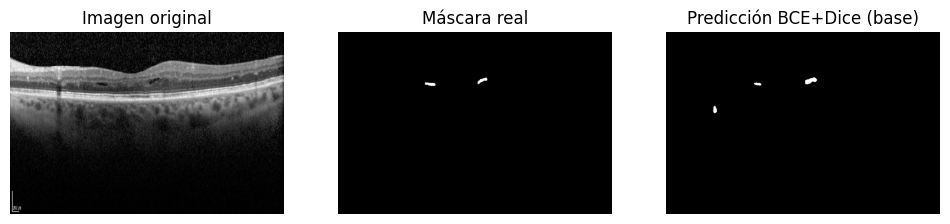

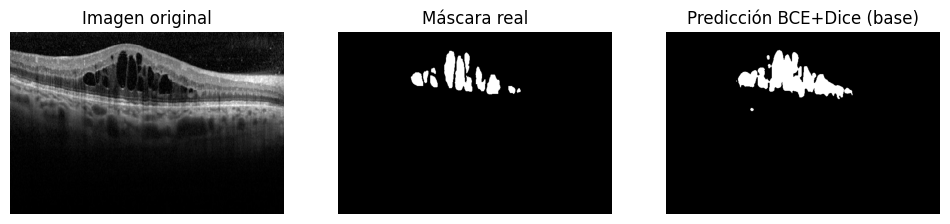

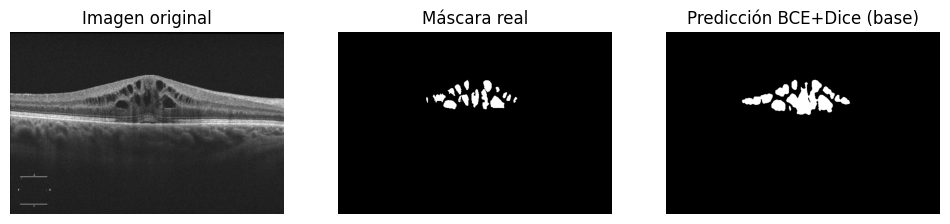

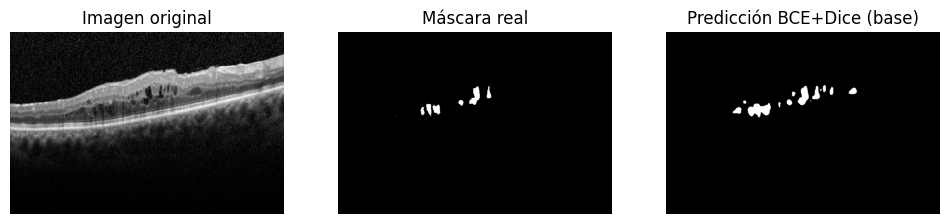

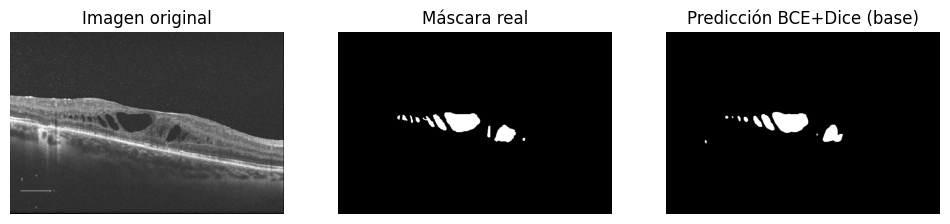

In [ ]:
thresh = 0.9
model_bce_dice.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model_bce_dice(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(8, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción BCE+Dice (base)")
            for a in ax: a.axis('off')
            plt.show()
        break


### Con arquitectura mejorada

In [ ]:
# Modelo mejorado
model_full = UNet(input_channels=1, n_class=1).to(device)

# BCE + Dice como pérdida
criterion = BCEDiceLoss(bce_weight=0.5, pos_weight=torch.tensor([60.0]).to(device))
optimizer = optim.Adam(model_full.parameters(), lr=1e-4)

model_path_full = "best_unet_full_combo.pth"
best_val_loss = float('inf')

# Entrenamiento
for epoch in range(50):
    model_full.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_full(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    model_full.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_full(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"[{epoch+1}/50] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_full.state_dict(), model_path_full)
        print(" ↳ Modelo BCE+Dice (mejorado) guardado")

[1/50] Train Loss: 0.9851 | Val Loss: 1.1200
 ↳ Modelo BCE+Dice (mejorado) guardado
[2/50] Train Loss: 0.8327 | Val Loss: 1.1255
[3/50] Train Loss: 0.7978 | Val Loss: 1.1394
[4/50] Train Loss: 0.7784 | Val Loss: 1.1586
[5/50] Train Loss: 0.7425 | Val Loss: 1.1789
[6/50] Train Loss: 0.7149 | Val Loss: 1.2055
[7/50] Train Loss: 0.7153 | Val Loss: 1.2252
[8/50] Train Loss: 0.7036 | Val Loss: 1.1717
[9/50] Train Loss: 0.6714 | Val Loss: 0.9382
 ↳ Modelo BCE+Dice (mejorado) guardado
[10/50] Train Loss: 0.6775 | Val Loss: 0.7841
 ↳ Modelo BCE+Dice (mejorado) guardado
[11/50] Train Loss: 0.6522 | Val Loss: 0.6601
 ↳ Modelo BCE+Dice (mejorado) guardado
[12/50] Train Loss: 0.6588 | Val Loss: 0.6809
[13/50] Train Loss: 0.6295 | Val Loss: 0.6671
[14/50] Train Loss: 0.6245 | Val Loss: 0.6288
 ↳ Modelo BCE+Dice (mejorado) guardado
[15/50] Train Loss: 0.6127 | Val Loss: 0.6244
 ↳ Modelo BCE+Dice (mejorado) guardado
[16/50] Train Loss: 0.6096 | Val Loss: 0.6496
[17/50] Train Loss: 0.6121 | Val Loss: 

#### Evaluación y métricas

In [ ]:
# Evaluación del modelo mejorado con BCE+Dice
model_full.load_state_dict(torch.load("best_unet_full_combo.pth"))
model_full.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results_full_combo = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_full(images)
            preds = get_binary_mask(outputs, threshold=thresh)
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = (precision * recall) / (precision + recall)

    results_full_combo[i] = [thresh, iou, acc, precision, recall, f1]


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, results_full_combo[:, 1], label="IoU")
plt.plot(thresholds, results_full_combo[:, 2], label="Accuracy")
plt.plot(thresholds, results_full_combo[:, 3], label="Precision")
plt.plot(thresholds, results_full_combo[:, 4], label="Recall")
plt.plot(thresholds, results_full_combo[:, 5], label="F1-Score")
plt.legend()
plt.title("Métricas - BCE + Dice (Mejorado + Augmentación)")
plt.xlabel("Umbral")
plt.grid(True)
plt.show()


In [ ]:
metrics_full_df = pd.DataFrame(results_full_combo, columns=["Threshold", "IoU", "Accuracy", "Precision", "Recall", "F1-Score"])
print("Resumen de métricas por umbral:")
display(metrics_full_df)


Resumen de métricas por umbral:


Threshold     IoU  Accuracy  Precision  Recall  F1-Score
0        0.05  0.0142    0.0142     0.0142  1.0000    0.0140
1        0.10  0.0142    0.0142     0.0142  1.0000    0.0140
2        0.15  0.0400    0.6615     0.0400  0.9970    0.0385
3        0.20  0.2445    0.9567     0.2451  0.9897    0.1964
4        0.25  0.3084    0.9687     0.3096  0.9879    0.2357
5        0.30  0.3473    0.9738     0.3490  0.9865    0.2578
6        0.35  0.3715    0.9764     0.3736  0.9852    0.2709
7        0.40  0.3931    0.9785     0.3956  0.9839    0.2822
8        0.45  0.4137    0.9803     0.4167  0.9827    0.2926
9        0.50  0.4334    0.9818     0.4370  0.9814    0.3024
10       0.55  0.4540    0.9833     0.4583  0.9797    0.3123
11       0.60  0.4761    0.9848     0.4813  0.9780    0.3225
12       0.65  0.4976    0.9861     0.5039  0.9757    0.3323
13       0.70  0.5203    0.9873     0.5278  0.9735    0.3422
14       0.75  0.5441    0.9885     0.5535  0.9698    0.3524
15       0.80  0.5695    0.9897     0.5814  0.9655    0.3629
16       0.85  0.5978    0.9909     0.6135  0.9588    0.3741
17       0.90  0.6301    0.9921     0.6539  0.9454    0.3865
18       0.95  0.6700    0.9936     0.7138  0.9161    0.4012

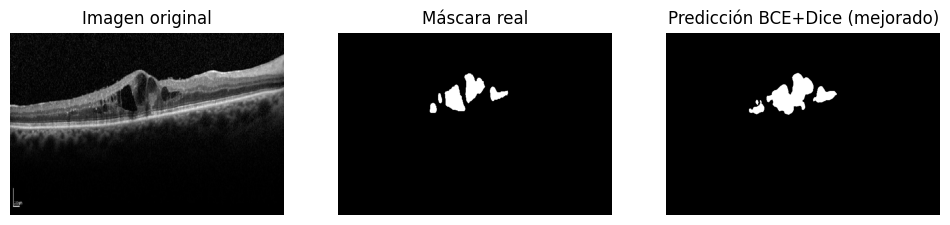

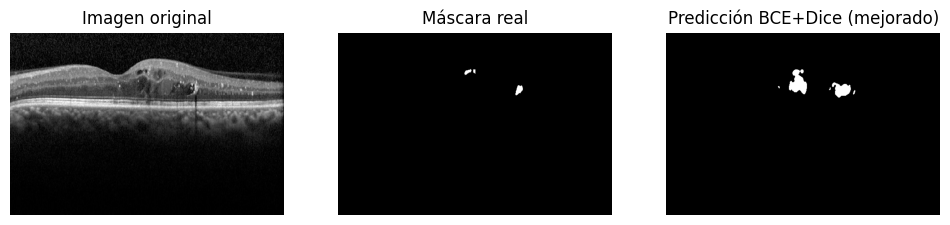

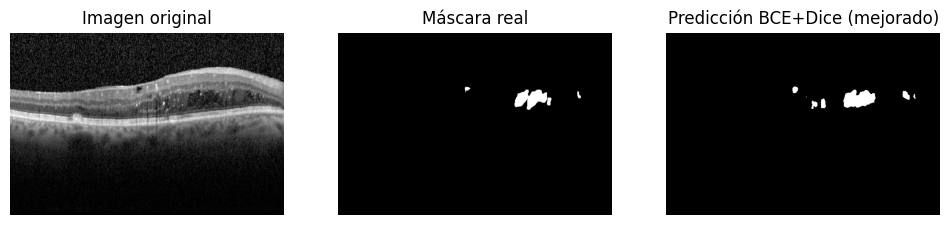

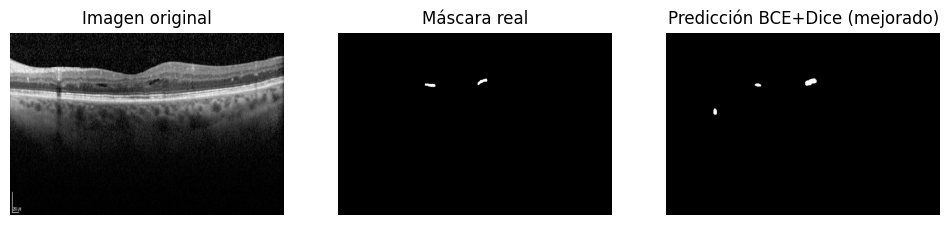

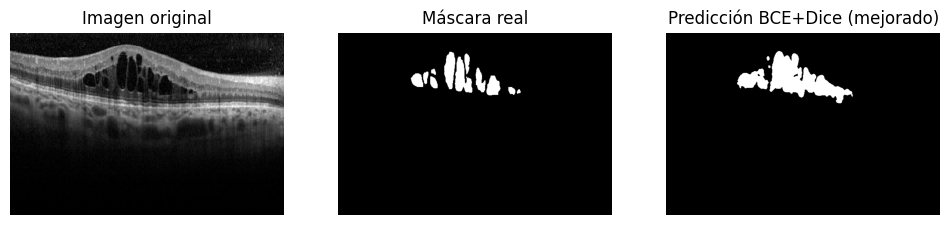

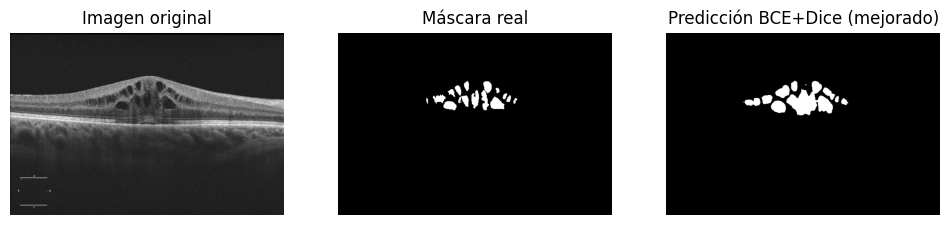

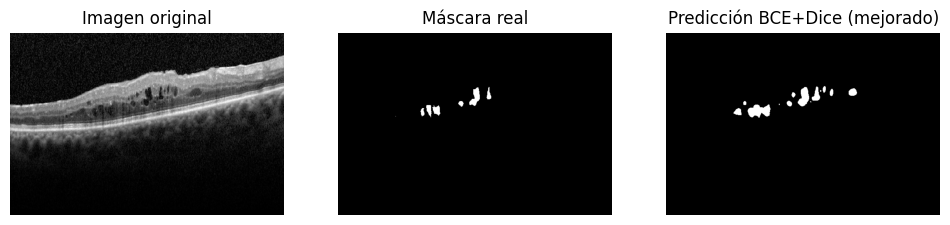

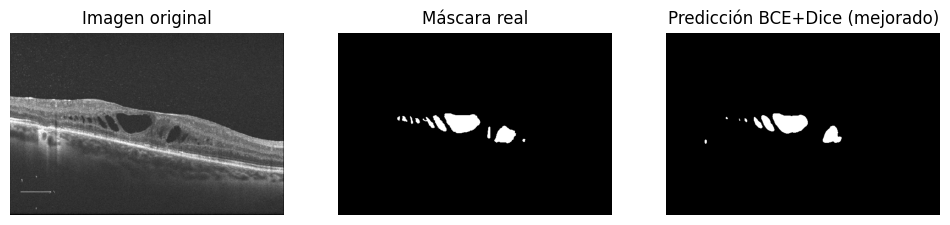

In [ ]:
thresh = 0.9
model_full.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model_full(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(8, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción BCE+Dice (mejorado)")
            for a in ax: a.axis('off')
            plt.show()
        break
